<a href="https://colab.research.google.com/github/Dimiboi1553/Chess-Genetic-Algorithm/blob/main/GENETIC_ALGORITHM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chess
!pip install chess.engine
!pip install threading
!pip install time
!apt-get install stockfish

In [ ]:
import chess
import chess.engine
import threading
import time
import random
import chess.svg
from IPython.display import SVG, display
from collections import defaultdict
import math
import multiprocessing

Main Class which handles Bot Creation and input of Numbers

In [ ]:
class Bot():
    def __init__(self,name,FreePieceMultiplier,EndgameFactor,EarlyGameFactor,PST_Multiplier,InactivityPenalty,InactivityPenalty_Pawn, InactivityPenalty_Queen
                ,GoodCapture,AttackingPiecesMultiplier):
        self.name = name
        self.score = 0
        self.NodesVisited = 0
        self.ZOBRIST_PIECES = [[[0] * 64 for _ in range(12)] for _ in range(2)]
        self.transposition_table = {}
        self.board = chess.Board()
        self.FreePieceMultiplier = FreePieceMultiplier
        self.EndgameFactor = EndgameFactor
        self.EarlyGameFactor = EarlyGameFactor
        self.PST_Multiplier = PST_Multiplier
        self.InactivityPenalty = InactivityPenalty
        self.InactivityPenalty_Pawn = InactivityPenalty_Pawn
        self.InactivityPenalty_Queen = InactivityPenalty_Queen
        self.GoodCapture = GoodCapture
        self.AttackingPiecesMultiplier = AttackingPiecesMultiplier
        self.ENDGAME_PAWN_TABLE = [
            [70, 70, 70, 70, 70, 70, 70, 70],
            [60, 60, 60, 60, 60, 60, 60, 60],
            [50, 50, 50, 50, 50, 50, 50, 50],
            [40, 40, 40, 40, 40, 40, 40, 40],
            [30, 30, 30, 30, 30, 30, 30, 30],
            [20, 20, 20, 20, 20, 20, 20, 20],
            [10, 10, 10, 10, 10, 10, 10, 10],
            [0, 0, 0, 0, 0, 0, 0, 0]
        ]

        self.STARTING_TABLE = [
            ["r", "n", "b", "q", "k", "b", "n", "r"],
            ["p", "p", "p", "p", "p", "p", "p", "p"],
            [" ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " "],
            [" ", " ", " ", " ", " ", " ", " ", " "],
            ["P", "P", "P", "P", "P", "P", "P", "P"],
            ["R", "N", "B", "Q", "K", "B", "N", "R"]
        ]

        self.pieceValues = {
            chess.PAWN: 100,
            chess.KNIGHT: 320,
            chess.BISHOP: 330,
            chess.ROOK: 500,
            chess.QUEEN: 900,
            chess.KING: 0
        }

        self.POTENTIAL_ATTACK_TABLE = [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0]
        ]

        self.ATTACK_TABLE = [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0]
        ]

        self.PAWN_TABLE = [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [50, 50, 50, 50, 50, 50, 50, 50],
            [10, 10, 20, 30, 30, 20, 10, 10],
            [5, 5, 10, 25, 25, 10, 5, 5],
            [0, 0, 0, 20, 20, 0, 0, 0],
            [5, -5, -10, 0, 0, -10, -5, 5],
            [5, 10, 10, -20, -20, 10, 10, 5],
            [0, 0, 0, 0, 0, 0, 0, 0]
        ]

        self.KNIGHT_TABLE = [
            [-50, -40, -30, -30, -30, -30, -40, -50],
            [-40, -20, 0, 0, 0, 0, -20, -40],
            [-30, 0, 10, 15, 15, 10, 0, -30],
            [-30, 5, 15, 20, 20, 15, 5, -30],
            [-30, 0, 15, 20, 20, 15, 0, -30],
            [-30, 5, 10, 15, 15, 10, 5, -30],
            [-40, -20, 0, 5, 5, 0, -20, -40],
            [-50, -40, -30, -30, -30, -30, -40, -50]
        ]

        self.BISHOPS_TABLE = [
            [-20, -10, -10, -10, -10, -10, -10, -20],
            [-10, 0, 0, 0, 0, 0, 0, -10],
            [-10, 0, 5, 10, 10, 5, 0, -10],
            [-10, 5, 5, 10, 10, 5, 5, -10],
            [-10, 0, 10, 10, 10, 10, 0, -10],
            [-10, 10, 10, 10, 10, 10, 10, -10],
            [-10, 5, 0, 0, 0, 0, 5, -10],
            [-20, -10, -10, -10, -10, -10, -10, -20]
        ]

        self.ROOKS_TABLE = [
            [0, 0, 0, 0, 0, 0, 0, 0],
            [5, 10, 10, 10, 10, 10, 10, 5],
            [-5, 0, 0, 0, 0, 0, 0, -5],
            [-5, 0, 0, 0, 0, 0, 0, -5],
            [-5, 0, 0, 0, 0, 0, 0, -5],
            [-5, 0, 0, 0, 0, 0, 0, -5],
            [-5, 0, 0, 0, 0, 0, 0, -5],
            [0, 0, 0, 5, 5, 0, 0, 0]
        ]

        self.QUEEN_TABLE = [
            [-20, -10, -10, -5, -5, -10, -10, -20],
            [-10, 0, 0, 0, 0, 0, 0, -10],
            [-10, 0, 5, 5, 5, 5, 0, -10],
            [-5, 0, 5, 5, 5, 5, 0, -5],
            [0, 0, 5, 5, 5, 5, 0, -5],
            [-10, 5, 5, 5, 5, 5, 0, -10],
            [-10, 0, 5, 0, 0, 0, 0, -10],
            [-20, -10, -10, -5, -5, -10, -10, -20]
        ]

        self.KING_TABLE = [
            [-30, -40, -40, -50, -50, -40, -40, -30],
            [-30, -40, -40, -50, -50, -40, -40, -30],
            [-30, -40, -40, -50, -50, -40, -40, -30],
            [-30, -40, -40, -50, -50, -40, -40, -30],
            [-20, -30, -30, -40, -40, -30, -30, -20],
            [-10, -20, -20, -20, -20, -20, -20, -10],
            [20, 20, 0, 0, 0, 0, 20, 20],
            [20, 30, 10, 0, 0, 10, 30, 20]
        ]

    def iterative_deepening_abpruning(self, board, max_depth, time_limit):
      best_move = None
      best_score = -float('inf')
      start_time = time.time()
      nodes_visited = 0

      for depth in range(1, max_depth + 1):
          if best_move == None:
            score, move, nodes_visited_at_depth = self.ABPruning(board, depth, -float('inf'), float('inf'), True, None)
            nodes_visited += nodes_visited_at_depth
          else:
            score, move, nodes_visited_at_depth = self.ABPruning(board, depth, -float('inf'), float('inf'), True, best_move=best_move)
            nodes_visited += nodes_visited_at_depth

          if score > best_score:
              best_score = score
              best_move = move

          elapsed_time = time.time() - start_time
          if elapsed_time >= time_limit:
              break

      self.NodesVisited = nodes_visited  # Update the total nodes visited
      return best_score, best_move, nodes_visited

    def ABPruning(self, game, depth, alpha, beta, maximizing_player, best_move):
        self.NodesVisited += 1

        if game.is_game_over() or depth == 0:
            if game.is_checkmate():
                if game.result() == '0-1':
                    return -99999 - depth, best_move, self.NodesVisited
                else:
                    return 99999 + depth, best_move, self.NodesVisited

            evaluation = self.Eval(game, depth)

            if evaluation != 0:
                return evaluation, best_move, self.NodesVisited

            return 0, best_move, self.NodesVisited

        val_moves = list(game.legal_moves)
        ordered_moves = self.OrderMoves(game, val_moves)

        if maximizing_player:
            max_eval = -999999
            for move in ordered_moves:
                copy = game.copy()
                copy.push(move)
                eval, _, nodes_visited = self.ABPruning(copy, depth - 1, alpha, beta, False, move)
                if eval > max_eval:
                    max_eval = eval
                    best_move = move
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval, best_move, self.NodesVisited
        else:
            min_eval = 999999
            for move in ordered_moves:
                copy = game.copy()
                copy.push(move)
                eval, _, nodes_visited = self.ABPruning(copy, depth - 1, alpha, beta, True, move)
                if eval < min_eval:
                    min_eval = eval
                    best_move = move
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval, best_move, self.NodesVisited



    def OrderMoves(self, game, moves):
        non_draw_moves = []

        for move in moves:
            copy = game.copy()
            copy.push(move)

            if not copy.is_insufficient_material() and not copy.is_seventyfive_moves() and not copy.is_fivefold_repetition():
                src_square = move.from_square
                piece = game.piece_at(src_square)
                if piece.piece_type != chess.KING :
                    non_draw_moves.append(move)

        non_draw_moves.sort(key=lambda move: self.move_priority(game, move), reverse=True)

        return non_draw_moves

    def move_priority(self, game, move):
      game1 = game.copy()
      game1.push(move)
      if game1.is_checkmate():
          return 4
      if move.promotion is not None:
          return 3
      if game1.is_capture(move):  # Use is_capture to check if a move is a capture
          return 2
      if game1.is_castling(move):
          return 1
      src_square = move.from_square
      piece = game1.piece_at(src_square)
      if piece.piece_type == chess.KING:
          if len(game1.epd()) <= 30:
              return 2
          return 1
      elif piece.piece_type == chess.PAWN and len(game1.epd()) <= 30:
          return 2

      copy = game.copy()
      copy.push(move)
      if copy.is_insufficient_material() or copy.is_seventyfive_moves() or copy.is_fivefold_repetition():
          return -1

      return 0


    def Eval(self, game, depth):
        zobrist_key = self.calculate_zobrist_key(game)

        # Check if the position is already in the transposition table
        if zobrist_key in self.transposition_table:
            return self.transposition_table[zobrist_key]

        if game is None or game is None:
            # Handle invalid input, perhaps return an error or default score
            return 0

        NoOfPieces = 0
        WhiteScore = 0
        BlackScore = 0

        if game.is_checkmate():
            print("Found Checkmate")
            if depth > 0:
                if game.result() == "0-1":
                    FinalScore = -99999 + depth
                else:
                    FinalScore = 99999 + depth
            return FinalScore

        safety = self.CalculateCaptures(game)

        for sq in chess.SQUARES:
            piece = game.piece_at(sq)

            if piece is not None:
                value = self.pieceValues[piece.piece_type]
                NoOfPieces += 1

                if piece.color == chess.BLACK:
                    if (self.ATTACK_TABLE[sq // 8][sq % 8]) == -1:
                        BlackScore -= self.pieceValues[piece.piece_type]
                    if (self.POTENTIAL_ATTACK_TABLE[sq // 8][sq % 8]) == -1:
                        BlackScore -= self.pieceValues[piece.piece_type]

                    if piece.piece_type == chess.PAWN:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "p":
                            BlackScore -= self.InactivityPenalty_Pawn
                        if NoOfPieces <= 15:
                            BlackScore += (self.ENDGAME_PAWN_TABLE[sq // 8][sq % 8] * 5) + value
                        else:
                            BlackScore += (self.PAWN_TABLE[sq // 8][sq % 8] * self.PST_Multiplier) + value
                    elif piece.piece_type == chess.KNIGHT:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "n":
                            BlackScore -= self.InactivityPenalty
                        BlackScore += (self.KNIGHT_TABLE[sq // 8][sq % 8] * self.PST_Multiplier) + value
                    elif piece.piece_type == chess.BISHOP:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "b":
                            BlackScore -= self.InactivityPenalty
                        BlackScore += (self.BISHOPS_TABLE[sq // 8][sq % 8] * self.PST_Multiplier) + value
                    elif piece.piece_type == chess.ROOK:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "r":
                            BlackScore -= self.InactivityPenalty
                        BlackScore += (self.ROOKS_TABLE[sq // 8][sq % 8] * self.PST_Multiplier) + value
                    elif piece.piece_type == chess.QUEEN:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "q":
                            BlackScore -= self.InactivityPenalty_Queen
                        BlackScore += (self.QUEEN_TABLE[sq // 8][sq % 8] * self.PST_Multiplier) + value
                else:
                    if (self.ATTACK_TABLE[sq // 8][sq % 8]) == -1:
                        WhiteScore -= self.pieceValues[piece.piece_type]
                    if (self.POTENTIAL_ATTACK_TABLE[sq // 8][sq % 8]) == -1:
                        WhiteScore -= self.pieceValues[piece.piece_type]

                    if piece.piece_type == chess.PAWN:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "P":
                            WhiteScore -= self.InactivityPenalty_Pawn
                        if NoOfPieces <= 15:
                            WhiteScore += (self.ENDGAME_PAWN_TABLE[sq // 8][sq % 8] * -5) + value + self.EndgameFactor
                        else:
                            WhiteScore += (self.PAWN_TABLE[sq // 8][sq % 8]) + value
                    elif piece.piece_type == chess.KNIGHT:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "N":
                            WhiteScore -= self.InactivityPenalty
                        WhiteScore += (self.KNIGHT_TABLE[sq // 8][sq % 8] * self.PST_Multiplier) + value
                    elif piece.piece_type == chess.BISHOP:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "B":
                            WhiteScore -= self.InactivityPenalty
                        WhiteScore += (self.BISHOPS_TABLE[sq // 8][sq % 8] * self.PST_Multiplier) + value
                    elif piece.piece_type == chess.ROOK:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "R":
                            WhiteScore -= self.InactivityPenalty
                        WhiteScore += (self.ROOKS_TABLE[sq // 8][sq % 8] * self.PST_Multiplier) + value
                    elif piece.piece_type == chess.QUEEN:
                        if self.STARTING_TABLE[sq // 8][sq % 8] == "Q":
                            WhiteScore -= self.InactivityPenalty
                        WhiteScore += (self.QUEEN_TABLE[sq // 8][sq % 8] * self.PST_Multiplier) + value

        WhiteMobility, BlackMobility = 50, 50
        FinalScore = (WhiteScore + WhiteMobility) - (BlackScore + BlackMobility) + safety

        if depth > 0:
            if game.result() == "0-1":
                FinalScore = -99999 + depth
            else:
                FinalScore = 99999 + depth

        self.transposition_table[zobrist_key] = FinalScore

        return FinalScore

    def calculate_zobrist_key(self, board):
        zobrist_key = 0
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece is not None:
                piece_type = piece.piece_type
                color = piece.color
                zobrist_key ^= self.ZOBRIST_PIECES[color][piece_type][square]
        return zobrist_key

    def IsInCheck(self, game):
        moves = list(game.mainline_moves())

        if len(moves) == 0:
            return False

        lastMove = moves[-1]

        return lastMove in game.checks()

    def findCaptures(self, board):
      captures = []
      for move in board.legal_moves:
          if board.is_capture(move):
              fromSquare = move.from_square
              toSquare = move.to_square
              capturingPiece = board.piece_at(fromSquare)
              capturedPiece = board.piece_at(toSquare)

              if capturingPiece is not None and capturedPiece is not None:
                  captures.append(move)
      return captures



    def CalculateCaptures(self, board):
        whiteSafety = 0
        blackSafety = 0
        EvaluateCapture = 0

        attackingPieces = {chess.WHITE: [], chess.BLACK: []}
        copy = board.copy()
        captures = self.findCaptures(copy)

        for capture in captures:
            fromSquare = capture.from_square
            targetSquare = capture.to_square

            capturingPiece = board.piece_at(fromSquare)
            capturedPiece = board.piece_at(targetSquare)

            # Check if capturingPiece and capturedPiece are not None
            if capturingPiece is not None and capturedPiece is not None:
                capturedValue = self.pieceValues[capturedPiece.piece_type]
                capturingValue = self.pieceValues[capturingPiece.piece_type]

                if capturedPiece.color == board.turn:
                    if capturedPiece.color == chess.BLACK:
                        blackSafety -= capturedValue
                    else:
                        whiteSafety -= capturedValue

                    if not self.IsPieceProtected(board, capture, targetSquare):
                        EvaluateCapture += capturedValue * self.FreePieceMultiplier
                    else:
                        if capturingPiece.piece_type == chess.QUEEN and capturedPiece.piece_type == chess.QUEEN:
                            EvaluateCapture += 100
                        else:
                            EvaluateCapture += capturedValue - capturingValue
                else:
                    if capturedPiece.color == chess.BLACK:
                        blackSafety -= capturedValue
                    else:
                        whiteSafety -= capturedValue

                    if not self.IsPieceProtected(board, capture, targetSquare):
                        EvaluateCapture += capturedValue * 2
                    else:
                        if capturingPiece.piece_type == chess.QUEEN and capturedPiece.piece_type == chess.QUEEN:
                            EvaluateCapture += self.GoodCapture
                        else:
                            EvaluateCapture += capturedValue - capturingValue

                    whiteSafety += self.IsFriendlyProtected(board, capturingPiece, capturedPiece, capture, targetSquare)
                    attackingPieces[capturedPiece.color].append(capturingPiece)

        if len(attackingPieces[chess.WHITE]) > 1:
            whiteSafety += (len(attackingPieces[chess.WHITE]) - 1) * self.AttackingPiecesMultiplier
        if len(attackingPieces[chess.BLACK]) > 1:
            whiteSafety -= (len(attackingPieces[chess.BLACK]) - 1) * self.AttackingPiecesMultiplier

        return whiteSafety - blackSafety + EvaluateCapture



    def IsPieceProtected(self,game, move, targetSquare):
      i = 0
      copyGame = game.copy()
      copyGame.push(move)
      captures = copyGame.legal_moves

      for capture in captures:
          self.ATTACK_TABLE[targetSquare // 8][targetSquare % 8] = -1
          if capture in copyGame.board().capture_pieces():
              if capture.to_square == targetSquare:
                  i += 1

      return i > 0



    def IsFriendlyProtected(self,game, capturingPiece, targetPiece, move, targetSquare):
      if self.IsPieceProtected(game, move, targetSquare):
          if capturingPiece.color == targetPiece.color:
              return self.pieceValues[targetPiece.piece_type] - self.pieceValues[capturingPiece.piece_type]
          return -self.pieceValues[targetPiece.piece_type] + self.pieceValues[capturingPiece.piece_type]
      else:
          if targetPiece.piece_type == chess.QUEEN:
              return -self.pieceValues[targetPiece.piece_type]
          return -self.pieceValues[targetPiece.piece_type]

    def IsAttackingPieceProtected(self,game, move):
      fromSquare = move.from_square
      targetSquare = move.to_square

      attackingPiece = game.piece_at(fromSquare)
      targetedPiece = game.piece_at(targetSquare)

      if self.IsPieceProtected(game, move, targetSquare):
          return self.pieceValues[targetedPiece.piece_type] - self.pieceValues[attackingPiece.piece_type]

      return self.pieceValues[targetedPiece.piece_type]


Separate Function to the give the AI a seperate thread to speed up computation


In [ ]:
def iterative_deepening_bot_turn(board, bot, max_depth, time_limit):
    _, best_move,nodesVisted = bot.iterative_deepening_abpruning(board, max_depth=4, time_limit=1)
    if best_move is not None:
        #print("Bot's move:", best_move,"Nodes Visted",nodesVisted)
        board.push(best_move)
        return best_move

    else:
        print("Bot couldn't find a valid move.")
        _, best_move,nodesVisted = bot.iterative_deepening_abpruning(board, max_depth=4, time_limit=1)
        if best_move is not None:
          board.push(best_move)
          return best_move

In [ ]:
def play_games_with_stockfish(num_games,bot_name):
    bot_wins = 0
    stockfish_wins = 0
    draws = 0
    engine = chess.engine.SimpleEngine.popen_uci('/usr/games/stockfish')

    for _ in range(num_games):
        board = chess.Board()
        while not board.is_game_over():
          # Bot's turn
          #bot_thread = threading.Thread(target=iterative_deepening_bot_turn, args=(board, bot, 4, 5))
          bestMove = iterative_deepening_bot_turn(board,bot,4,5)
          board.push(bestMove)
          # bot_thread.start()
          # bot_thread.join()  # Wait for the bot's move to complete
          if board.is_game_over():
              board_svg = chess.svg.board(board=board,size=350)
              display(SVG(board_svg))
              print("Bot wins")
              result = board.result()
              if result == "0-1":
                  stockfish_wins += 1
              elif result == "1-0":
                  bot_wins += 1
              elif result == "1/2-1/2":
                  draws += 1

          # Player's turn
          result = engine.play(board, chess.engine.Limit(time=0.5))
          bot_move = result.move

          board.push(bot_move)

          if board.is_game_over():
              #board_svg = chess.svg.board(board=board,size=350)
              #display(SVG(board_svg))
              result = board.result()
              if result == "0-1":
                  stockfish_wins += 1
              elif result == "1-0":
                  bot_wins += 1
              elif result == "1/2-1/2":
                  draws += 1
    engine.quit()
    return bot_wins  + draws


In [ ]:
def simulate_games_with_bot(args):
    bot, num_games = args
    bot_scores = []
    for _ in range(num_games):
        score = play_games_with_stockfish(1, bot.name)
        bot_scores.append(score)
    return bot_scores

Firstly we are going to create 10 different bots, with pseudo-random parameters

Name: Gen 0 Dimibot Bot 1
FreePieceMultiplier: 5
EndgameFactor: 470
EarlyGameFactor: 83
PST_Multiplier: 5
InactivityPenalty: -99
InactivityPenalty_Pawn: -73
InactivityPenalty_Queen: -111
GoodCapture: 174
AttackingPiecesMultiplier: 189


Name: Gen 0 Dimibot Bot 2
FreePieceMultiplier: 4
EndgameFactor: 436
EarlyGameFactor: 577
PST_Multiplier: 2
InactivityPenalty: -105
InactivityPenalty_Pawn: -75
InactivityPenalty_Queen: -130
GoodCapture: 151
AttackingPiecesMultiplier: 176


Name: Gen 0 Dimibot Bot 3
FreePieceMultiplier: 1
EndgameFactor: 252
EarlyGameFactor: 601
PST_Multiplier: 7
InactivityPenalty: -110
InactivityPenalty_Pawn: -83
InactivityPenalty_Queen: -191
GoodCapture: 158
AttackingPiecesMultiplier: 193


Name: Gen 0 Dimibot Bot 4
FreePieceMultiplier: 3
EndgameFactor: 276
EarlyGameFactor: 495
PST_Multiplier: 2
InactivityPenalty: -109
InactivityPenalty_Pawn: -52
InactivityPenalty_Queen: -137
GoodCapture: 154
AttackingPiecesMultiplier: 97


Name: Gen 0 Dimibot Bot 5
FreePieceMultiplier: 

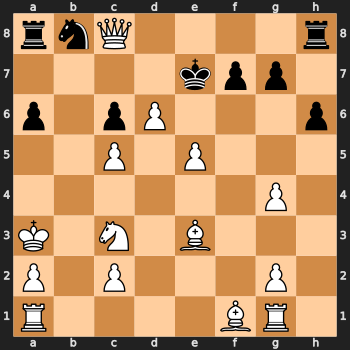

Bot wins
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.
Bot couldn't find a valid move.


AttributeError: ignored

In [ ]:
if __name__ == "__main__":
    num_generations = 47
    num_processes = 10  # Number of parallel processes
    num_games_per_bot = 10
    bots = []
    PreviousBest = -1
    for x in range(num_generations):
        if len(bots) == 0:
            # Init Gen 0
            for i in range(10):
                name = f"Gen {x} Dimibot Bot {i+1}"
                # Initialize Pseudo Random Values for Gen 0
                FreePieceMultiplier = random.randint(1, 5)
                EndgameFactor = random.randint(200, 500)
                EarlyGameFactor = random.randint(50, 700)
                PST_Multiplier = random.randint(2, 8)
                InactivityPenalty = random.randint(-110, -90)
                InactivityPenalty_Pawn = random.randint(-150, -50)
                InactivityPenalty_Queen = random.randint(-250, -50)
                GoodCapture = random.randint(80, 200)
                AttackingPiecesMultiplier = random.randint(90, 200)
                bot = Bot(name, FreePieceMultiplier, EndgameFactor, EarlyGameFactor, PST_Multiplier, InactivityPenalty, InactivityPenalty_Pawn, InactivityPenalty_Queen,
                          GoodCapture, AttackingPiecesMultiplier)
                bots.append(bot)

                print(f"Name: {bot.name}")
                print(f"FreePieceMultiplier: {bot.FreePieceMultiplier}")
                print(f"EndgameFactor: {bot.EndgameFactor}")
                print(f"EarlyGameFactor: {bot.EarlyGameFactor}")
                print(f"PST_Multiplier: {bot.PST_Multiplier}")
                print(f"InactivityPenalty: {bot.InactivityPenalty}")
                print(f"InactivityPenalty_Pawn: {bot.InactivityPenalty_Pawn}")
                print(f"InactivityPenalty_Queen: {bot.InactivityPenalty_Queen}")
                print(f"GoodCapture: {bot.GoodCapture}")
                print(f"AttackingPiecesMultiplier: {bot.AttackingPiecesMultiplier}")
                print("\n")

        # Simulate Games and calculate bot scores
        pool = multiprocessing.Pool(processes=num_processes)
        bot_scores = pool.map(simulate_games_with_bot, [(bot, num_games_per_bot) for bot in bots], chunksize=1)
        pool.close()
        pool.join()

        for i, bot in enumerate(bots):
            bot.score = sum(bot_scores[i])

        # Create Next Generation
        fitness = {}  # A dictionary to store the fitness of each bot
        generational_fitness = 0

        bestbot = ""
        for bot in bots:
          #Find best Bot
          if bot.score > PreviousBest:
            PreviousBest = bot.score
            Bestbot = bot

        print(f"Best Score {PreviousBest} Generational Fitness {generational_fitness}")
        print(f"Name: {Bestbot.name}")
        print(f"FreePieceMultiplier: {Bestbot.FreePieceMultiplier}")
        print(f"EndgameFactor: {Bestbot.EndgameFactor}")
        print(f"EarlyGameFactor: {Bestbot.EarlyGameFactor}")
        print(f"PST_Multiplier: {Bestbot.PST_Multiplier}")
        print(f"InactivityPenalty: {Bestbot.InactivityPenalty}")
        print(f"InactivityPenalty_Pawn: {Bestbot.InactivityPenalty_Pawn}")
        print(f"InactivityPenalty_Queen: {Bestbot.InactivityPenalty_Queen}")
        print(f"GoodCapture: {Bestbot.GoodCapture}")
        print(f"AttackingPiecesMultiplier: {Bestbot.AttackingPiecesMultiplier}")

        # Calculate fitness
        for bot in bots:
            fitness[bot] = bot.score
            generational_fitness += bot.score

        # Calculate probability
        p = {}  # A dictionary to store the probabilities of selection for each bot
        for bot in fitness:
            p[bot] = bot.score / generational_fitness

        # Calculate cumulative probabilities
        cumulative_prob = 0
        cumulative_p = {}  # A dictionary to store cumulative probabilities
        for bot in p:
            cumulative_prob += p[bot]
            cumulative_p[bot] = cumulative_prob

        # Select the next generation of bots
        new_bots = []
        for i in range(10):#We want the same population Bots! so in total 10
            new_name = f"Gen {x+1} Dimibot Bot {i+1}"
            r1 = random.random()
            r2 = random.random()
            mutation = random.random()
            ParamMutation = random.randint(1,9)
            parent1, parent2 = None, None

            for bot in cumulative_p:
                if r1 <= cumulative_p[bot]:
                    parent1 = bot
                    break
            #Parent 1 found now time for parent two
            for bot in cumulative_p:
                if r2 <= cumulative_p[bot]:
                    parent2 = bot
                    break
            #Found Parent 2!

            #Initialise all new parameters
            if i % 2 == 0:
              NewFreePieceMultiplier = parent2.FreePieceMultiplier
              NewEndgameFactor = parent1.EndgameFactor
              NewEarlyGameFactor =  parent2.EarlyGameFactor
              NewPST_Multiplier = parent1.PST_Multiplier

              NewInactivityPenalty = (parent1.InactivityPenalty + parent2.InactivityPenalty) / 2
              NewInactivityPenalty_Pawn = (parent1.InactivityPenalty_Pawn + parent2.InactivityPenalty_Pawn) / 2
              NewInactivityPenalty_Queen = (parent1.InactivityPenalty_Queen + parent2.InactivityPenalty_Queen) / 2
              NewGoodCapture = (parent1.GoodCapture + parent2.GoodCapture) / 2
              NewAttackingPiecesMultiplier = (parent1.AttackingPiecesMultiplier + parent2.AttackingPiecesMultiplier) / 2
            else:
              NewFreePieceMultiplier = (parent1.FreePieceMultiplier + parent2.FreePieceMultiplier) / 2
              NewEndgameFactor = (parent1.EndgameFactor + parent2.EndgameFactor) / 2
              NewEarlyGameFactor = (parent1.EarlyGameFactor + parent2.EarlyGameFactor) / 2
              NewPST_Multiplier = (parent1.PST_Multiplier + parent2.PST_Multiplier) / 2

              NewInactivityPenalty =  parent2.InactivityPenalty
              NewInactivityPenalty_Pawn = parent1.InactivityPenalty_Pawn
              NewInactivityPenalty_Queen = parent2.InactivityPenalty_Queen
              NewGoodCapture = parent1.GoodCapture
              NewAttackingPiecesMultiplier = parent2.AttackingPiecesMultiplier

            # NewInactivityPenalty = (parent1.InactivityPenalty + parent2.InactivityPenalty) / 2
            # NewInactivityPenalty_Pawn = (parent1.InactivityPenalty_Pawn + parent2.InactivityPenalty_Pawn) / 2
            # NewInactivityPenalty_Queen = (parent1.InactivityPenalty_Queen + parent2.InactivityPenalty_Queen) / 2
            # NewGoodCapture = (parent1.GoodCapture + parent2.GoodCapture) / 2
            # NewAttackingPiecesMultiplier = (parent1.AttackingPiecesMultiplier + parent2.AttackingPiecesMultiplier) / 2

            #Introduce Mutations:
            if mutation <= 0.1:
              match ParamMutation:
                case 1:
                  NewFreePieceMultiplier = random.randint(1, 5)
                case 2:
                  NewEndgameFactor = random.randint(200, 500)
                case 3:
                  NewEarlyGameFactor = random.randint(50, 700)
                case 4:
                  NewPST_Multiplier = random.randint(2, 8)
                case 5:
                  NewInactivityPenalty = random.randint(-110, -90)
                case 6:
                  NewInactivityPenalty_Pawn = random.randint(-150, -50)
                case 7:
                  NewInactivityPenalty_Queen = random.randint(-250, -50)
                case 8:
                  NewGoodCapture = random.randint(80,200)
                case 9:
                  NewAttackingPiecesMultiplier = random.randint(90, 200)

            #Add New Bot:
            new_bot = Bot(new_name, NewFreePieceMultiplier, NewEndgameFactor, NewEarlyGameFactor, NewPST_Multiplier, NewInactivityPenalty,
                  NewInactivityPenalty_Pawn, NewInactivityPenalty_Queen, NewGoodCapture, NewAttackingPiecesMultiplier)
            print(f"Name: {new_bot.name}")
            print(f"FreePieceMultiplier: {new_bot.FreePieceMultiplier}")
            print(f"EndgameFactor: {new_bot.EndgameFactor}")
            print(f"EarlyGameFactor: {new_bot.EarlyGameFactor}")
            print(f"PST_Multiplier: {new_bot.PST_Multiplier}")
            print(f"InactivityPenalty: {new_bot.InactivityPenalty}")
            print(f"InactivityPenalty_Pawn: {new_bot.InactivityPenalty_Pawn}")
            print(f"InactivityPenalty_Queen: {new_bot.InactivityPenalty_Queen}")
            print(f"GoodCapture: {new_bot.GoodCapture}")
            print(f"AttackingPiecesMultiplier: {new_bot.AttackingPiecesMultiplier}")
            print("\n")
            new_bots.append(new_bot)
            # Replace the old generation with the new one
        bots = new_bots

In [ ]:
#we need to make the cumulative chances of selecting each parent

# #calculate fitness

# for bot in bots:
#   fitness[bot] = bot.score
#   generational_fitness += bot.score

# #calculate probability
# for bot in fitness:
#   p[bot] = bot.score / generational_fitness

# #calculate cumulative
# for bot in p
#   #add ps of previous untill now


In [ ]:



#We will spin the roulette X times

#2 times to select parents
#5 pairs of parents

#X = 10 times

  # for i in range(10):
  #   random.randint(0,100)


#select parents based on culumative *100

#------------------------------------


#Reproduction

#select a method:

#half of the attributes from each parent?

#50-50 chance of inheritance from each parent for each attribute?

#average of parents' numerical values? SELECTED \/

# {noOfGen}Dimibot{no}.EndgameFactor = (parent1.EGF + parent2.EGF)/2


